In [1]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import torch
import loss
import tqdm
import pyproj

import cv2

plt.rc('figure', figsize=(15, 15))

In [2]:
p = pathlib.Path(f'data/data_random_50.npz')
res = np.load(p)

times = res['times']
x = res['x']
x_osgb = res['x_osgb']
y = res['y']
y_osgb = res['y_osgb']
data = res['data']

In [45]:
data.shape

(2661, 891, 1843)

In [4]:
# we should probably do the pv angle not this
# start_hour = 8
# end_hour = 15

# def extract_hour(dt: np.datetime64):
#     return (dt.astype('M8[h]') - dt.astype('M8[D]')).astype(int)

# # get ok times
# times_mask = []
# for i in range(len(times)):
#     if start_hour <= extract_hour(times[i]) <= end_hour:
#         times_mask.append(i)
        
# # grab the data in the right time range
# times = times[times_mask]
# data = data[times_mask]

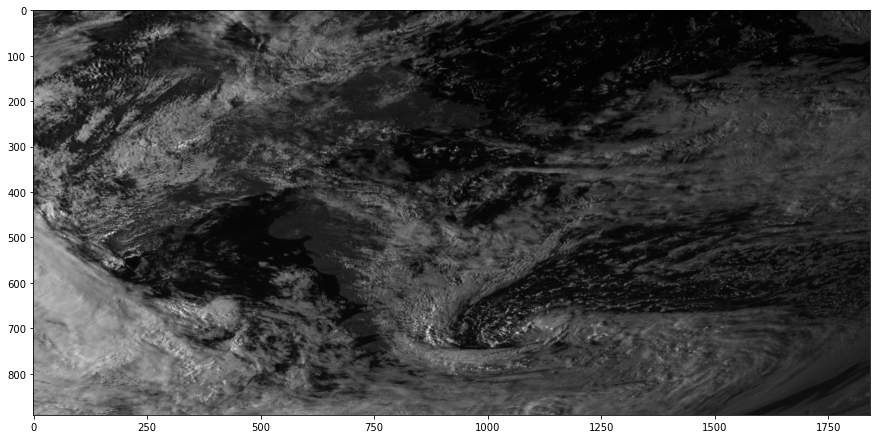

In [46]:
plt.imshow(data[0], cmap='gray')

In [47]:
times[:30]

array(['2020-07-26T07:00:00.000000000', '2020-07-26T07:05:00.000000000',
       '2020-07-26T07:10:00.000000000', '2020-07-26T07:15:00.000000000',
       '2020-07-26T07:20:00.000000000', '2020-07-26T07:25:00.000000000',
       '2020-07-26T07:30:00.000000000', '2020-07-26T07:35:00.000000000',
       '2020-07-26T07:40:00.000000000', '2020-07-26T07:45:00.000000000',
       '2020-07-26T07:50:00.000000000', '2020-07-26T07:55:00.000000000',
       '2020-07-26T08:00:00.000000000', '2020-07-26T08:05:00.000000000',
       '2020-07-26T08:10:00.000000000', '2020-07-26T08:15:00.000000000',
       '2020-07-26T08:20:00.000000000', '2020-07-26T08:25:00.000000000',
       '2020-07-26T08:30:00.000000000', '2020-07-26T08:35:00.000000000',
       '2020-07-26T08:40:00.000000000', '2020-07-26T08:45:00.000000000',
       '2020-07-26T08:50:00.000000000', '2020-07-26T08:55:00.000000000',
       '2020-07-26T09:00:00.000000000', '2020-07-26T09:05:00.000000000',
       '2020-07-26T09:10:00.000000000', '2020-07-26

In [48]:
def get_crop_idxs():
    rand_x = np.random.randint(550, 950 - 128)
    rand_y = np.random.randint(375, 700 - 128)
    
    yslice = slice(rand_y, rand_y + 128)
    xslice = slice(rand_x, rand_x + 128)
    
    return xslice, yslice
    
    
def get_mssim(y, x):
    if len(y.shape) == 2:
        # we need to specify a number of channels. This sets it to 1 and calls the function again
        return get_mssim(np.expand_dims(y, 0), np.expand_dims(x, 0))
    assert len(y.shape) == 3
    mssim_loss = loss.MS_SSIMLoss(channels=y.shape[0])
    yd = np.expand_dims(y, 0) # /255 * (MAX - MIN) + MIN
    xd = np.expand_dims(x, 0) # /255 * (MAX - MIN) + MIN
    return 1.0 - mssim_loss(
        torch.Tensor(yd),
        torch.Tensor(xd),
    )

In [49]:
# look at same prediction
np.random.seed(7)

scores = []
running_total = 0

pbar = tqdm.notebook.tqdm(range(0, len(times) - 24, 10))
for idx in pbar:
    diff = (times[idx+24].astype('M8[m]') - times[idx].astype('M8[m]')).astype(int)
    if diff != 120:
        continue
    
    crops = 30
    _scores = []
    for i in range(crops):
        xslice, yslice = get_crop_idxs()
        x = data[idx, yslice, xslice]
        ys = np.zeros((24, 64, 64))
        yhats = np.zeros((24, 64, 64))
        for j in range(1, 25):
            y = data[idx + j, yslice, xslice]
            # grab middle 64x64 and compare
            ys[j - 1, :, :] = y[32:32+64,32:32+64]
            yhats[j - 1, :, :] = x[32:32+64,32:32+64]
        
        # get the MSSSIM for this crop and its forward propogation prediction
        score = float(get_mssim(ys, yhats))
        _scores.append(score)
        running_total += score
    
    scores.append(_scores)
    pbar.set_description(f'MSSIM: {running_total/(len(scores) * crops)}')
    


  0%|          | 0/264 [00:00<?, ?it/s]

In [50]:
scores = np.array(scores)

In [51]:
np.mean(scores)

0.6269670534902398

In [52]:
np.mean(scores)

0.6269670534902398

In [53]:
worst = np.unravel_index(np.argmin(scores), scores.shape)
worst

(32, 24)

In [54]:
scores[worst]

0.04692244529724121

In [ ]:
# MIN = 0
# MAX = 1023

# # we need to normalize in this range to use optical flow
# data -= MIN
# data = data / (MAX - MIN)
# data *= 255
# data = data.astype(np.uint8)

In [6]:
flows_default = cv2.calcOpticalFlowFarneback(
    prev=data[0],
    next=data[1],
    flow=None,
    pyr_scale=0.5, levels=3, winsize=15, 
    iterations=10, poly_n=5, poly_sigma=1.2, 
    flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

In [7]:
flows_default.shape

(891, 1843, 2)

In [8]:
idx = np.unravel_index(np.argmax(flows_default), flows_default.shape)[:2]
idx

(277, 207)

In [9]:
flows_default[idx]

array([10.332372 , -6.4321537], dtype=float32)

In [10]:
# example, without interpolation
pred = data[0][idx[1] + round(flows_default[idx][1]), idx[0] + round(flows_default[idx][0])]
original = data[1][idx]
actual = data[0][idx]

print(pred, original, actual)

62 100 72


In [11]:
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

In [56]:
forecast = 7
pred = warp_flow(data[0], flows_default * forecast)

In [57]:
# this is better!
get_mssim(data[forecast], pred)

tensor(0.9263)

In [58]:
get_mssim(data[forecast], data[0])

tensor(0.9285)

In [74]:
# basic optical flow
np.random.seed(7)

scores = []
running_total = 0

pbar = tqdm.notebook.tqdm(range(0, len(times) - 25, 10))
for idx in pbar:
    diff = (times[idx+25].astype('M8[m]') - times[idx].astype('M8[m]')).astype(int)
    if diff != 125:
        continue
    
    crops = 30
    _scores = []
    for i in range(crops):
        xslice, yslice = get_crop_idxs()
        prev = data[idx, yslice, xslice]
        cur = data[idx + 1, yslice, xslice]
        flow = cv2.calcOpticalFlowFarneback(
            prev=prev,
            next=cur,
            flow=None,
            pyr_scale=0.5, levels=3, winsize=15, 
            iterations=10, poly_n=5, poly_sigma=1.2, 
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
        )
        
        ys = np.zeros((24, 64, 64), dtype=np.float32)
        yhats = np.zeros((24, 64, 64), dtype=np.float32)
        for j in range(1, 25):
            y = data[idx + j, yslice, xslice]
            if j <= 6:
                # if the multiplier is not too bad, do this: 
                # apply the flow `i` iterations
                yhat = warp_flow(cur, flow * j)
            else:
                # otherwise, stick with the original prediction
                yhat = cur
            
            # grab middle 64x64 and compare
            ys[j - 2, :, :] = y[32:32+64,32:32+64]
            yhats[j - 2, :, :] = yhat[32:32+64,32:32+64]
        
        # get the MSSSIM for this crop and its forward propogation prediction
        score = float(get_mssim(ys, yhats))
        _scores.append(score)
        running_total += score
        
    scores.append(_scores)
    pbar.set_description(f'MSSIM: {running_total/(len(scores) * crops)}')
    

In [62]:
scores = np.array(scores)

In [63]:
np.mean(scores)

0.6632048956818684

In [66]:
# basic optical flow, but try optical flow prediction
np.random.seed(7)

scores = []
running_total = 0

pbar = tqdm.notebook.tqdm(range(0, len(times) - 25, 10))
for idx in pbar:
    diff = (times[idx+25].astype('M8[m]') - times[idx].astype('M8[m]')).astype(int)
    if diff != 125:
        continue
    
    crops = 30
    _scores = []
    for i in range(crops):
        xslice, yslice = get_crop_idxs()
        prev = data[idx, yslice, xslice]
        cur = data[idx + 1, yslice, xslice]
        flow = cv2.calcOpticalFlowFarneback(
            prev=prev,
            next=cur,
            flow=None,
            pyr_scale=0.5, levels=3, winsize=15, 
            iterations=10, poly_n=5, poly_sigma=1.2, 
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
        )
        
        ys = np.zeros((24, 64, 64))
        yhats = np.zeros((24, 64, 64))
        for j in range(1, 25):
            y = data[idx + j, yslice, xslice]
            cutoff = 6
            yhat = warp_flow(cur, flow * j)
            if j <= cutoff:
                # if the multiplier is not too bad, do this: 
                # apply the flow `i` iterations
                yhat = warp_flow(cur, flow * j)[32:32+64,32:32+64]
            else:
                # otherwise, stick with the last optical flow prediction
                yhat = yhats[cutoff - 2]
            
            # grab middle 64x64 and compare
            ys[j - 2, :, :] = y[32:32+64,32:32+64]
            yhats[j - 2, :, :] = yhat
        
        # get the MSSSIM for this crop and its forward propogation prediction
        score = float(get_mssim(ys, yhats))
        _scores.append(score)
        running_total += score
        
    scores.append(_scores)
    pbar.set_description(f'MSSIM: {running_total/(len(scores) * crops)}')
    

  0%|          | 0/530 [00:00<?, ?it/s]

In [67]:
scores = np.array(scores)

In [68]:
np.mean(scores)

0.6490924645532382